In [ ]:
#Import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob as gb
import shutil

#Tensorflow Lib
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import optimizers

#Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import mean_squared_error

#Transfer Learning
from tensorflow.keras.applications import VGG19


#file paths
train_path = 'seg_train/'
test_path = 'seg_test/'
pred_path = 'seg_pred/pred'
shutil.unpack_archive('archive.zip')

#Data download is from the following https://www.kaggle.com/puneet6060/intel-image-classification

# Data Loading

In [2]:
"""Check the content of training data"""
size = []
file_count = 0
for folder in os.listdir(train_path):
    files = gb.glob(pathname=str(train_path+folder+'/*.jpg'))
    print(f'For training data found: {len(files)} files in folder: {folder}')
    file_count += len(files)
    for file in files:
        img = plt.imread(file)
        size.append(img.shape)
print(f'Total file Count is: {file_count}') 
print(f'{pd.Series(size).value_counts()[0]/file_count:.2%} percent of the files are of the size {pd.Series(size).value_counts().index[0]}')
print(f'{sum(pd.Series(size).value_counts()[1:])} files are of a unique size')

For training data found: 2191 files in folder: buildings
For training data found: 2271 files in folder: forest
For training data found: 2404 files in folder: glacier
For training data found: 2512 files in folder: mountain
For training data found: 2274 files in folder: sea
For training data found: 2382 files in folder: street
Total file Count is: 14034
99.66% percent of the files are of the size (150, 150, 3)
48 files are of a unique size


In [3]:
"""Check the content of testing data"""
size = []
file_count = 0
for folder in os.listdir(test_path):
    files = gb.glob(pathname=str(test_path+folder+'/*.jpg'))
    print(f'For Test data found: {len(files)} files in folder: {folder}')
    file_count += len(files)
    
    for file in files:
        img = plt.imread(file)
        size.append(img.shape)
        
print(f'Total file count is: {file_count}')
print(f'{pd.Series(size).value_counts()[0]/file_count:.2%} percent of the files are of the size {pd.Series(size).value_counts().index[0]}')
print(f'{sum(pd.Series(size).value_counts()[1:])} files are of a unique size')

For Test data found: 437 files in folder: buildings
For Test data found: 474 files in folder: forest
For Test data found: 553 files in folder: glacier
For Test data found: 525 files in folder: mountain
For Test data found: 510 files in folder: sea
For Test data found: 501 files in folder: street
Total file count is: 3000
99.77% percent of the files are of the size (150, 150, 3)
7 files are of a unique size


In [7]:
size=[]
files = gb.glob(pathname = str(pred_path+'/*.jpg'))
print(f'For prediction data we have {len(files)} files')
for file in files:
        img = plt.imread(file)
        size.append(img.shape)
print(f'{pd.Series(size).value_counts()[0]/len(files):.2%} percent of the files are of the size {pd.Series(size).value_counts().index[0]}')
print(f'{sum(pd.Series(size).value_counts()[1:])} files are of a unique size')

For prediction data we have 7301 files
99.82% percent of the files are of the size (150, 150, 3)
13 files are of a unique size


## Image Data Generators

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    batch_size=64,
                                                    classes = os.listdir(train_path),
                                                    class_mode='sparse',
                                                    target_size=(150,150))
validation_generator = test_datagen.flow_from_directory(test_path,
                                                        batch_size=64,
                                                        classes = os.listdir(train_path),
                                                        class_mode='sparse',
                                                        target_size=(150,150))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Model

In [9]:
CNN = Sequential()

CNN.add(Conv2D(32,(3,3), activation='relu', input_shape=(150,150,3)))
CNN.add(MaxPooling2D(pool_size=(2,2)))
for i in [64,128,128]:
    CNN.add(Conv2D(i,(3,3), activation='relu'))
    CNN.add(MaxPooling2D(pool_size=(2,2)))
    CNN.add(Dropout(0.25))

CNN.add(Flatten())

#Fully Connected Layer
for i in [256,512]:
    CNN.add(Dense(i,activation='relu'))
    
CNN.add(Dense(6,activation='softmax'))

In [10]:
CNN.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = 'adam', metrics=['accuracy'])

In [11]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0

In [12]:
history = CNN.fit(train_generator, 
                    epochs=50, 
                    validation_data=validation_generator,
                    verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 220 steps, validate for 47 steps
Epoch 1/50
220/220 - 71s - loss: 1.2061 - accuracy: 0.5041 - val_loss: 1.0168 - val_accuracy: 0.5867
Epoch 2/50
220/220 - 72s - loss: 0.9639 - accuracy: 0.6119 - val_loss: 0.7282 - val_accuracy: 0.7253
Epoch 3/50
220/220 - 75s - loss: 0.7844 - accuracy: 0.7064 - val_loss: 0.6734 - val_accuracy: 0.7570
Epoch 4/50
220/220 - 75s - loss: 0.6919 - accuracy: 0.7424 - val_loss: 0.5268 - val_accuracy: 0.8223
Epoch 5/50
220/220 - 72s - loss: 0.6194 - accuracy: 0.7681 - val_loss: 0.4996 - val_accuracy: 0.8147
Epoch 6/50
220/220 - 73s - loss: 0.5714 - accuracy: 0.7870 - val_loss: 0.5110 - val_accuracy: 0.8133
Epoch 7/50
220/220 - 74s - loss: 0.5449 - accuracy: 0.7990 - val_loss: 0.4990 - val_accuracy: 0.8260
Epoch 8/50
220/220 - 78s - loss: 0.5236 - accuracy: 0.8094 - val_loss: 0.4347 - val_accuracy: 0.8477
Epoch 9/50
220/220 - 79s - loss: 0.4897 - accuracy: 0.8232 - val_loss: 0.4901 - val_accuracy: 0.824

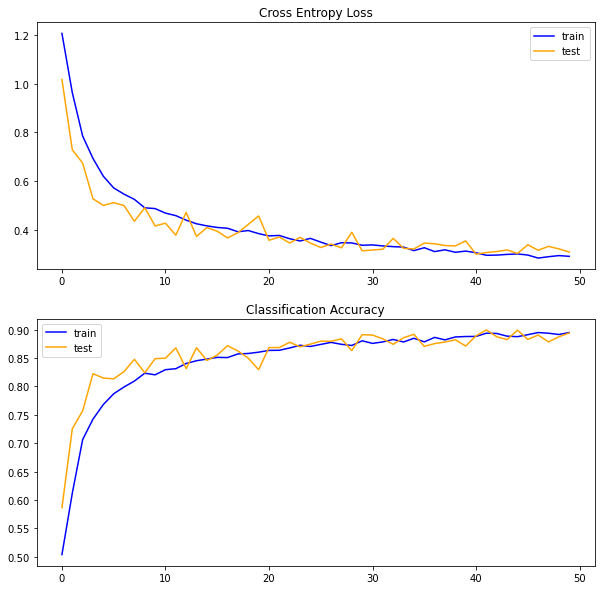

In [13]:
#Plotting History
fig, axs = plt.subplots(2,1,figsize=(10,10))
axs[0].title.set_text('Cross Entropy Loss')
axs[0].plot(history.history['loss'], color='blue', label='train')
axs[0].plot(history.history['val_loss'], color='orange', label='test')
axs[0].legend()
axs[1].title.set_text('Classification Accuracy')
axs[1].plot(history.history['accuracy'], color='blue', label='train')
axs[1].plot(history.history['val_accuracy'], color='orange', label='test')
axs[1].legend()

In [14]:
#Evaluate the model
acc = CNN.evaluate(validation_generator,verbose=0)
print("Evaluate on test data")
print("Test Loss: {}, Test Acc: {}".format(acc[0],acc[1]))

  ...
    to  
  ['...']
Evaluate on test data
Test Loss: 0.3081485264478846, Test Acc: 0.8939999938011169


# Transfer Learning

In [15]:
#Transfer Model
modelT = VGG19(include_top=False, input_shape=(150,150,3))
for layer in modelT.layers:
    layer.trainable=False
    
#Setting up the FC layer
x = modelT.layers[-1].output
x = Flatten()(x)

for i in [256,512]:
    x = Dense(i,activation='relu')(x)
    x = Dropout(0.25)(x)
    
x = Dense(6,activation='softmax')(x)

#Define the final model
modelT = Model(inputs=modelT.inputs, outputs=x)
modelT.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [16]:
modelT.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [17]:
historyT = modelT.fit(train_generator, 
                      epochs=50, 
                      validation_data=validation_generator,
                      verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 220 steps, validate for 47 steps
Epoch 1/50
220/220 - 81s - loss: 0.7092 - accuracy: 0.7225 - val_loss: 0.4031 - val_accuracy: 0.8517
Epoch 2/50
220/220 - 79s - loss: 0.5473 - accuracy: 0.7976 - val_loss: 0.3978 - val_accuracy: 0.8540
Epoch 3/50
220/220 - 81s - loss: 0.5118 - accuracy: 0.8103 - val_loss: 0.3770 - val_accuracy: 0.8703
Epoch 4/50
220/220 - 82s - loss: 0.4835 - accuracy: 0.8251 - val_loss: 0.3510 - val_accuracy: 0.8747
Epoch 5/50
220/220 - 82s - loss: 0.4569 - accuracy: 0.8278 - val_loss: 0.3525 - val_accuracy: 0.8700
Epoch 6/50
220/220 - 81s - loss: 0.4491 - accuracy: 0.8339 - val_loss: 0.3823 - val_accuracy: 0.8573
Epoch 7/50
220/220 - 82s - loss: 0.4493 - accuracy: 0.8339 - val_loss: 0.3580 - val_accuracy: 0.8727
Epoch 8/50
220/220 - 82s - loss: 0.4394 - accuracy: 0.8377 - val_loss: 0.3585 - val_accuracy: 0.8690
Epoch 9/50
220/220 - 82s - loss: 0.4347 - accuracy: 0.8409 - val_loss: 0.3425 - val_accuracy: 0.875

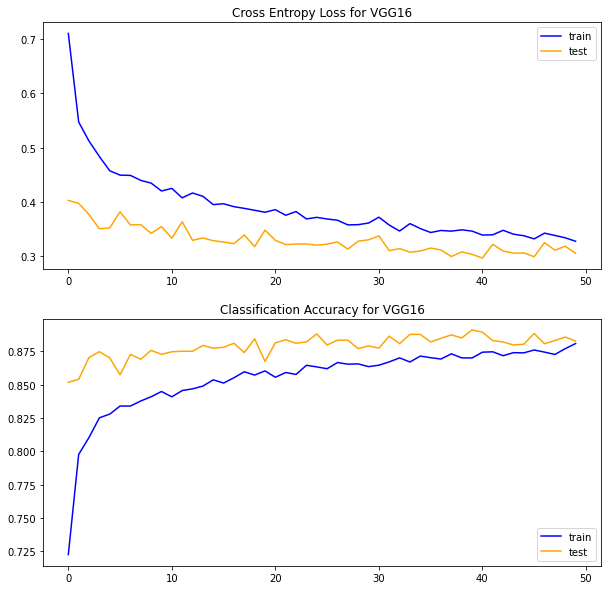

In [18]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
axs[0].title.set_text('Cross Entropy Loss for VGG16')
axs[0].plot(historyT.history['loss'], color='blue', label='train')
axs[0].plot(historyT.history['val_loss'], color='orange', label='test')
axs[0].legend()
axs[1].title.set_text('Classification Accuracy for VGG16')
axs[1].plot(historyT.history['accuracy'], color='blue', label='train')
axs[1].plot(historyT.history['val_accuracy'], color='orange', label='test')
axs[1].legend()

In [19]:
#Evaluate the model
acc = modelT.evaluate(validation_generator,verbose=0)
print("Evaluate on test data")
print("Test Loss: {}, Test Acc: {}".format(acc[0],acc[1]))

  ...
    to  
  ['...']
Evaluate on test data
Test Loss: 0.3058409551356701, Test Acc: 0.8826666474342346


In [20]:
CNN.save('CNN_model')
modelT.save('Transfer_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: CNN_model\assets
INFO:tensorflow:Assets written to: Transfer_model\assets


# Prediction

In [85]:
#Defining prediction Image Data generator
pred_datagen = ImageDataGenerator(rescale=1./255)
class_dictionary = os.listdir(train_path)
pred_generator = pred_datagen.flow_from_directory(pred_path,
                                                  batch_size=73,
                                                  class_mode=None,
                                                  shuffle=True,
                                                  target_size=(150,150))

Found 7301 images belonging to 1 classes.


In [86]:
#Getting Predictions from the models
predictions = CNN.predict_generator(pred_generator,100)
predictionsT = modelT.predict_generator(pred_generator,100)
print(f'The Prediction array size of CNN: {predictions.shape}')
print(f'The Prediction array size of Transfer Learning Model: {predictionsT.shape}')

The Prediction array size of CNN: (7300, 6)
The Prediction array size of Transfer Learning Model: (7300, 6)


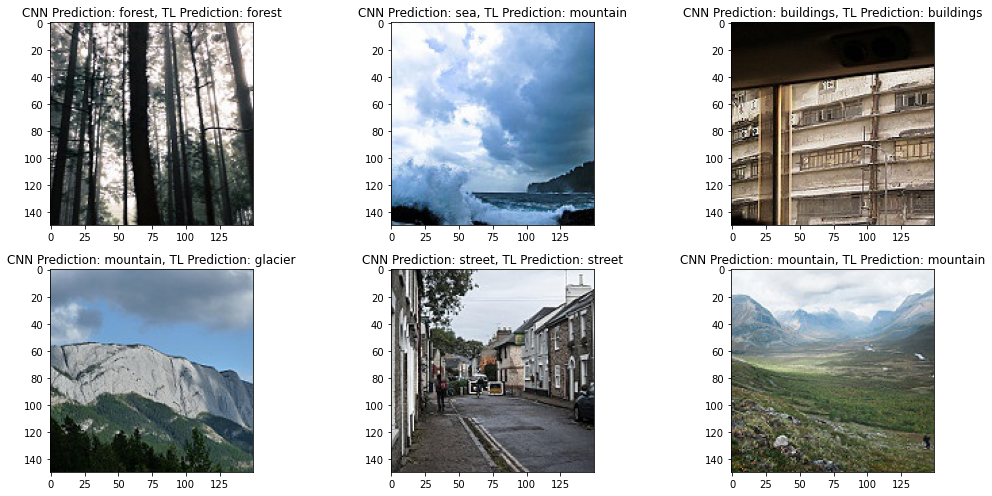

In [87]:
display_batch = next(pred_generator)
pred = CNN.predict(display_batch)
predT = modelT.predict(display_batch)
plt.figure(figsize=(15,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(display_batch[i])
    plt.title(f'CNN Prediction: {class_dictionary[np.argmax(pred[i])]}, TL Prediction: {class_dictionary[np.argmax(predT[i])]}')
    
plt.tight_layout()

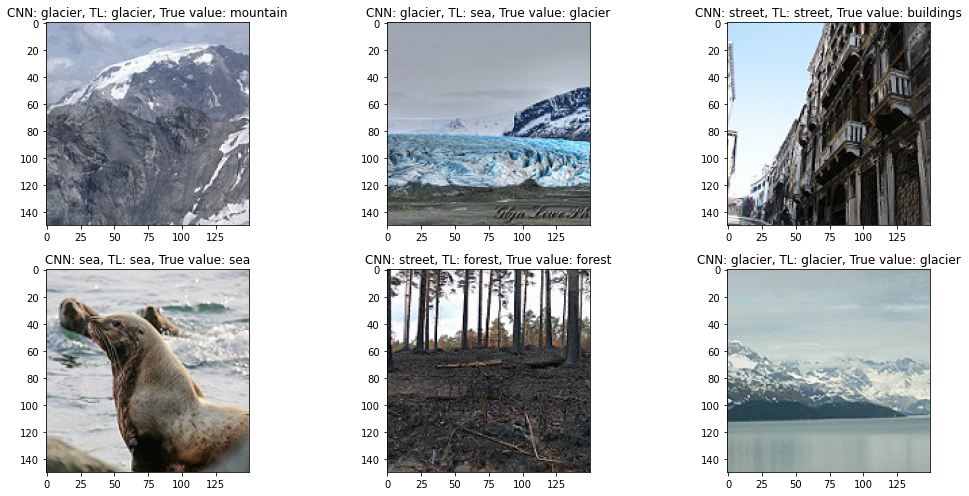

In [88]:
#Prediction on the test dataset
x_batch,y_batch = next(validation_generator)
pred = CNN.predict(x_batch)
predT = modelT.predict(x_batch)
plt.figure(figsize=(15,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_batch[i])
    plt.title(f'CNN: {class_dictionary[np.argmax(pred[i])]}, TL: {class_dictionary[np.argmax(predT[i])]}, True value: {class_dictionary[int(y_batch[i])]}')
    
plt.tight_layout()